In [ ]:
#--Phase 0: Historical data scraper to build a rich dataset for analysis and modeling.

from GoogleNews import GoogleNews
import pandas as pd
from datetime import datetime, timedelta
import time # Import the time library to add a small delay

# --- Configuration ---
tickers = ['AAPL', 'MSFT', 'GOOGL']
num_days_to_scrape = 180  #get a month of historical data

# --- Scraper Setup ---
googlenews = GoogleNews(lang='en', region='US')
googlenews.set_encode('utf-8')
all_articles = []

# --- The Scraping Loop ---
print(f"Starting historical scrape for the last {num_days_to_scrape} days...")
end_date = datetime.now()

for i in range(num_days_to_scrape):
    date_to_scrape = end_date - timedelta(days=i)
    date_str = date_to_scrape.strftime('%m/%d/%Y')
    
    # Set the time range for a single day
    googlenews.set_time_range(start=date_str, end=date_str)
    
    for ticker in tickers:
        print(f"  -> Searching for {ticker} news on {date_str}...")
        googlenews.clear() # Clear previous search results
        googlenews.get_news(f'{ticker} stock finance')
        results = googlenews.results(sort=True)
        
        for res in results:
            all_articles.append({
                'ticker': ticker.upper(),
                'headline': res.get('title'),
                'summary': res.get('desc'),
                'link': res.get('link'),
                'scraped_at': res.get('datetime') or date_to_scrape
            })
        
        time.sleep(1) # Add a 1-second delay to be respectful to the server

# --- Save to DataFrame and CSV ---
historical_df = pd.DataFrame(all_articles)
print(f"\nScraping complete! Found {len(historical_df)} historical articles.")

# Save the rich historical dataset to a new CSV file
historical_df.to_csv('historical_news_data.csv', index=False)
print("Historical data saved to 'historical_news_data.csv'.")

# Display the first few rows of your new historical dataset
historical_df.head()

In [1]:
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe

# --- Part 1: Load and Combine ALL News Data (Corrected) ---

# --- Step 1.1: Load Historical Data and Standardize ---
print("--- Step 1.1: Loading historical news data... ---")
try:
    historical_df = pd.read_csv('historical_news_data.csv')
    # Standardize columns IMMEDIATELY after loading
    historical_df.columns = historical_df.columns.str.lower().str.strip()
    print(f"Loaded {len(historical_df)} historical rows.")
except FileNotFoundError:
    print("Historical data file not found. Creating empty DataFrame.")
    historical_df = pd.DataFrame()

# --- Step 1.2: Load Live Data and Standardize ---
print("\n--- Step 1.2: Loading live news data from Google Sheets... ---")
try:
    gc = gspread.service_account(filename='credentials.json')
    worksheet = gc.open("Financial News Scraper").sheet1
    live_df = get_as_dataframe(worksheet, header=0)
    # Standardize columns IMMEDIATELY after loading
    live_df.columns = live_df.columns.str.lower().str.strip()
    print(f"Loaded {len(live_df)} live rows.")
except Exception as e:
    print(f"Could not load from Google Sheet. Error: {e}. Creating empty DataFrame.")
    live_df = pd.DataFrame()

# --- Step 1.3: Combine, Deduplicate, and Sort ---
print("\n--- Step 1.3: Combining all data... ---")

# Now that columns match, concat will work perfectly
df = pd.concat([historical_df, live_df], ignore_index=True)

# Remove any potential duplicate headlines
if 'headline' in df.columns:
    df = df.drop_duplicates(subset=['headline'], keep='last')

# Convert scraped_at to datetime and remove any rows where conversion fails
if 'scraped_at' in df.columns:
    df['scraped_at'] = pd.to_datetime(df['scraped_at'], errors='coerce')
    df = df.dropna(subset=['scraped_at'])
    # Sort the entire dataset by date
    df = df.sort_values(by='scraped_at', ascending=False).reset_index(drop=True)

print(f"\nSuccessfully combined all data. Total unique articles: {len(df)}")
df.head()

--- Step 1.1: Loading historical news data... ---
Loaded 767 historical rows.

--- Step 1.2: Loading live news data from Google Sheets... ---
Loaded 90 live rows.

--- Step 1.3: Combining all data... ---

Successfully combined all data. Total unique articles: 735


,ticker,headline,summary,link,scraped_at
0,GOOGL,Google's market value surge - how to invest now?,NaN,https://news.google.com/read/CBMiekFVX3lxTFBOd...,2025-08-25 22:03:28.665076
1,AAPL,Apple (AAPL) Considers Using Google Gemini to ...,NaN,https://news.google.com/read/CBMijAFBVV95cUxON...,2025-08-24 22:03:31.978909
2,AAPL,Apple (AAPL) vs. Amazon (AMZN): Which Is the B...,NaN,https://news.google.com/read/CBMihwFBVV95cUxOe...,2025-08-21 22:03:59.726656
3,GOOGL,Terawulf (WULF) Cracks Past New All-Time High ...,NaN,https://news.google.com/read/CBMiggFBVV95cUxQY...,2025-08-19 22:04:23.652763
4,GOOGL,Florida is now the 2nd most financially distre...,NaN,https://news.google.com/read/CBMihAFBVV95cUxPS...,2025-08-19 22:04:23.652763


In [2]:
#--Phase 2: Downloading stock data from Yahoo Finance and calculating volatility for chosen tickers..

import yfinance as yf
from pandas.tseries.offsets import BDay

# --- Part 2: Download, Prepare, and Merge Stock Data ---

# Note: The 'df' DataFrame with all our news data already exists from the previous cell.

print("--- Step 2: Downloading and preparing stock data... ---")

# A small improvement: We can get the list of tickers directly from our news data.
tickers = df['ticker'].unique().tolist()
start_date = '2022-01-01' # Go back far enough to ensure we have price history

stock_df_raw = yf.download(tickers, start=start_date, auto_adjust=True)
stock_df = stock_df_raw['Close'].stack().reset_index()
stock_df.columns = ['Date', 'ticker', 'Close']

stock_df = stock_df.sort_values(by=['ticker', 'Date'])
stock_df['daily_return'] = stock_df.groupby('ticker')['Close'].pct_change()
stock_df['volatility'] = stock_df.groupby('ticker')['daily_return'].rolling(window=7).std().reset_index(0,drop=True)
print("Stock data processed and volatility calculated.")


# --- Merge the datasets ---
print("\n--- Preparing to merge news and stock data... ---")

# Prepare date columns for merging
df['date'] = pd.to_datetime(df['scraped_at']).dt.date
stock_df['date'] = pd.to_datetime(stock_df['Date']).dt.date

# We use an 'inner' merge to ensure we only keep rows where we have BOTH news and stock data.
master_df = pd.merge(df, stock_df, on=['date', 'ticker'], how='inner')

# Drop any remaining rows that might have missing values
master_df = master_df.dropna(subset=['Close', 'volatility'])

print(f"Merge complete. Master DataFrame created with {len(master_df)} rows.")
master_df.head()

--- Step 2: Downloading and preparing stock data... ---


[*********************100%***********************]  3 of 3 completed

Stock data processed and volatility calculated.

--- Preparing to merge news and stock data... ---
Merge complete. Master DataFrame created with 619 rows.


,ticker,headline,summary,link,scraped_at,date,Date,Close,daily_return,volatility
0,GOOGL,Google's market value surge - how to invest now?,NaN,https://news.google.com/read/CBMiekFVX3lxTFBOd...,2025-08-25 22:03:28.665076,2025-08-25,2025-08-25,208.490005,0.011645,0.014601
1,AAPL,Apple (AAPL) vs. Amazon (AMZN): Which Is the B...,NaN,https://news.google.com/read/CBMihwFBVV95cUxOe...,2025-08-21 22:03:59.726656,2025-08-21,2025-08-21,224.899994,-0.004911,0.010432
2,GOOGL,Terawulf (WULF) Cracks Past New All-Time High ...,NaN,https://news.google.com/read/CBMiggFBVV95cUxQY...,2025-08-19 22:04:23.652763,2025-08-19,2025-08-19,201.570007,-0.009484,0.007366
3,GOOGL,Florida is now the 2nd most financially distre...,NaN,https://news.google.com/read/CBMihAFBVV95cUxPS...,2025-08-19 22:04:23.652763,2025-08-19,2025-08-19,201.570007,-0.009484,0.007366
4,GOOGL,FTSE 100 up and US stocks mixed as Zelensky-Pu...,NaN,https://news.google.com/read/CBMirAFBVV95cUxQT...,2025-08-19 22:04:23.652763,2025-08-19,2025-08-19,201.570007,-0.009484,0.007366


In [3]:
from transformers import pipeline
import pandas as pd

print("--- Step 3: Performing sentiment analysis... ---")

# --- Data Cleaning and Text Preparation ---
# Use master_df as the input
master_df['headline'] = master_df['headline'].fillna('')
master_df['summary'] = master_df['summary'].fillna('')

master_df['text_for_sentiment'] = master_df['headline'] + '. ' + master_df['summary']
print("Created a combined 'text_for_sentiment' column for analysis.")


# --- Load and Run the Model ---
print("Loading the FinBERT sentiment analysis model...")
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# This function remains the same
def get_sentiment_score(sentiment_result):
    if sentiment_result['label'] == 'positive':
        return sentiment_result['score']
    elif sentiment_result['label'] == 'negative':
        return -sentiment_result['score']
    else:
        return 0.0

print("\nApplying sentiment analysis to all articles... (This can take a few minutes)")

# Apply the pipeline to our new column in master_df
all_sentiments = sentiment_pipeline(master_df['text_for_sentiment'].tolist())
master_df['sentiment_score'] = [get_sentiment_score(s) for s in all_sentiments]

print("Sentiment analysis complete!")

# Display the master_df, which now includes the sentiment_score
master_df[['ticker', 'headline', 'sentiment_score']].head()

c:\Users\azmat\Financial-Volatility-Proj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Step 3: Performing sentiment analysis... ---
Created a combined 'text_for_sentiment' column for analysis.
Loading the FinBERT sentiment analysis model...

Applying sentiment analysis to all articles... (This can take a few minutes)
Sentiment analysis complete!


,ticker,headline,sentiment_score
0,GOOGL,Google's market value surge - how to invest now?,0.000000
1,AAPL,Apple (AAPL) vs. Amazon (AMZN): Which Is the B...,0.000000
2,GOOGL,Terawulf (WULF) Cracks Past New All-Time High ...,0.939226
3,GOOGL,Florida is now the 2nd most financially distre...,-0.938509
4,GOOGL,FTSE 100 up and US stocks mixed as Zelensky-Pu...,-0.896508


In [9]:
# --- CELL 4: Daily Aggregation ---

print("Aggregating article data to the daily level...")

# This groups the data and creates the final features with consistent names
daily_df = master_df.groupby(['date', 'ticker']).agg(
    # CORRECT NAME: 'mean_sentiment'
    mean_sentiment=('sentiment_score', 'mean'),
    
    sentiment_std=('sentiment_score', 'std'),
    news_volume=('headline', 'count'),
    
    # CORRECT NAME: 'Close' (capital C)
    Close=('Close', 'first'),
    
    volatility=('volatility', 'first')
).reset_index()

daily_df['sentiment_std'] = daily_df['sentiment_std'].fillna(0)

print(f"Created daily aggregated dataset with {len(daily_df)} rows.")
daily_df.head()

Aggregating article data to the daily level...
Created daily aggregated dataset with 252 rows.


,date,ticker,mean_sentiment,sentiment_std,news_volume,Close,volatility
0,2025-03-05,GOOGL,0.000000,0.000000,2,172.612015,0.019598
1,2025-03-05,MSFT,0.557375,0.000000,1,399.628174,0.019041
2,2025-03-06,GOOGL,-0.324263,0.561641,3,171.943588,0.018211
3,2025-03-10,AAPL,-0.959901,0.000000,1,226.924545,0.022596
4,2025-03-10,MSFT,0.929582,0.000000,1,378.840607,0.021522


Creating lag features...
Features created. Preparing data for modeling...
Data split into 43 training rows and 11 testing rows.
Training the XGBoost model...
Model training complete.
Making predictions on the test set...

--- Model Performance Breakdown by Ticker ---

--- Results for GOOGL ---
Mean Absolute Error (MAE): 0.005306


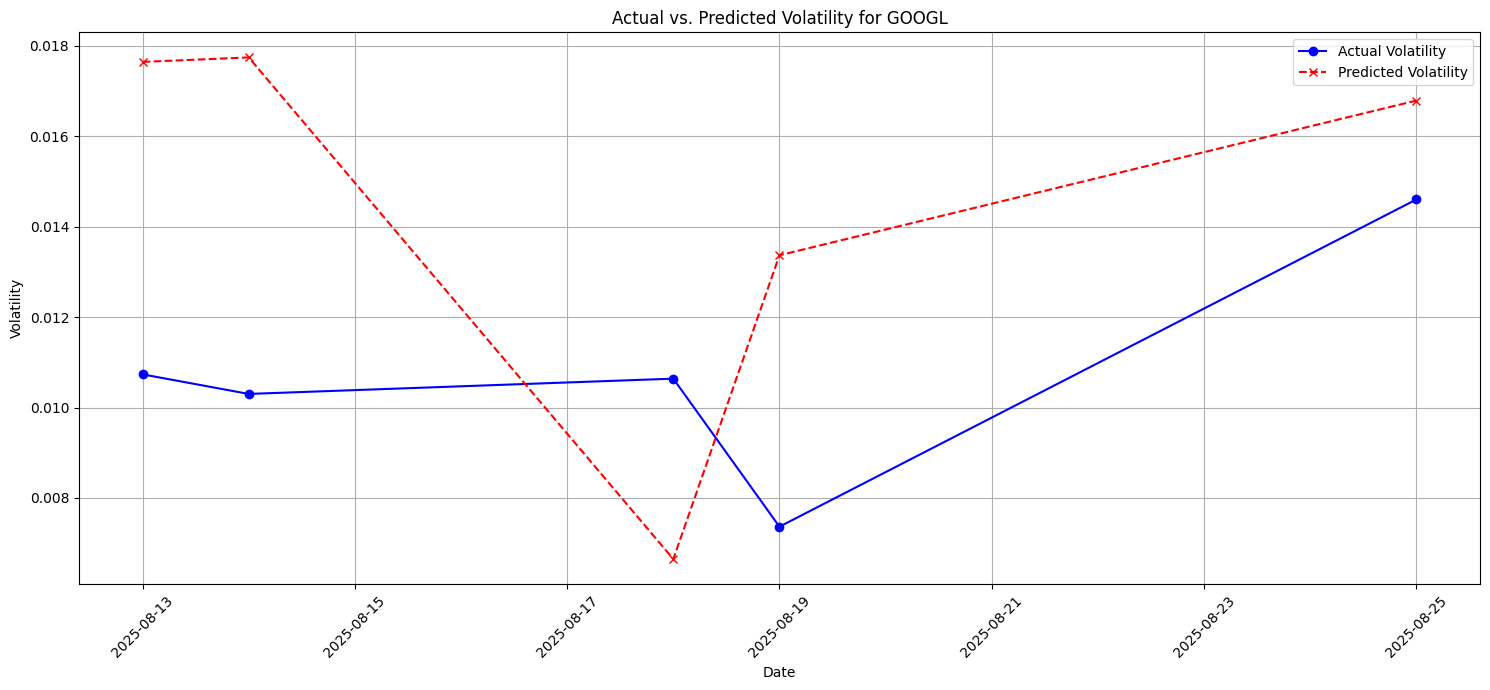


--- Results for MSFT ---
Mean Absolute Error (MAE): 0.003676


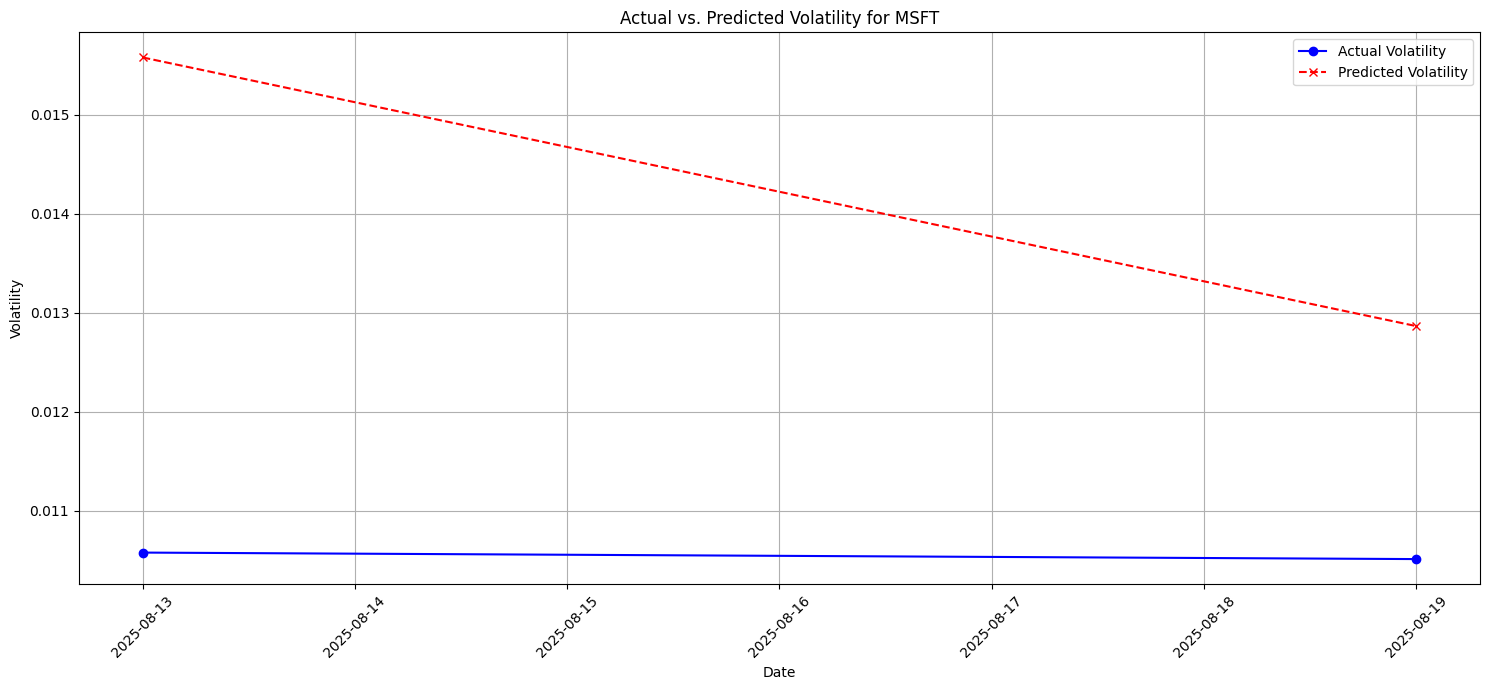


--- Results for AAPL ---
Mean Absolute Error (MAE): 0.005241


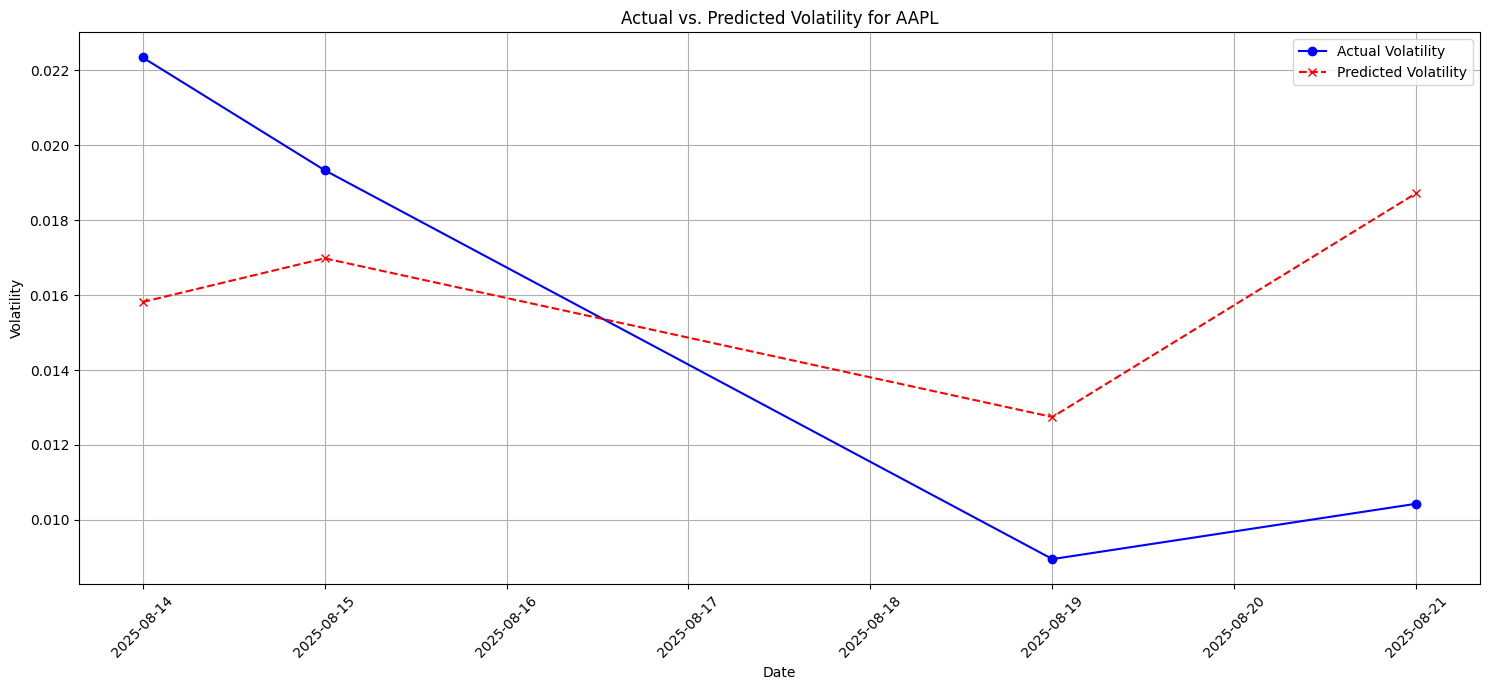

In [31]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# --- This first part of the cell remains the same ---

print("Creating lag features...")

for i in range(1, 4):
    daily_df[f'mean_sentiment_lag_{i}'] = daily_df.groupby('ticker')['mean_sentiment'].shift(i)
    daily_df[f'sentiment_std_lag_{i}'] = daily_df.groupby('ticker')['sentiment_std'].shift(i)
    daily_df[f'news_volume_lag_{i}'] = daily_df.groupby('ticker')['news_volume'].shift(i)

daily_df = daily_df.dropna()

print("Features created. Preparing data for modeling...")

y = daily_df['volatility']
X = daily_df.drop(columns=['date', 'ticker', 'Close', 'volatility'])

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Data split into {len(X_train)} training rows and {len(X_test)} testing rows.")

print("Training the XGBoost model...")
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
print("Model training complete.")

print("Making predictions on the test set...")
predictions = model.predict(X_test)


# --- NEW SECTION: Evaluate and Plot Results for Each Ticker ---

print("\n--- Model Performance Breakdown by Ticker ---")

# First, combine all test data into one DataFrame for easy filtering
results_df = X_test.copy()
results_df['date'] = daily_df.loc[y_test.index, 'date']
results_df['ticker'] = daily_df.loc[y_test.index, 'ticker']
results_df['actual_volatility'] = y_test
results_df['predicted_volatility'] = predictions

# Get the list of unique tickers in our test set
unique_tickers_in_test = results_df['ticker'].unique()

# Loop through each ticker to analyze and plot its results
for ticker in unique_tickers_in_test:
    
    # Filter for the current ticker
    ticker_results_df = results_df[results_df['ticker'] == ticker].sort_values('date')
    
    # Calculate the MAE for this specific ticker
    ticker_mae = mean_absolute_error(
        ticker_results_df['actual_volatility'], 
        ticker_results_df['predicted_volatility']
    )
    
    print(f"\n--- Results for {ticker} ---")
    print(f"Mean Absolute Error (MAE): {ticker_mae:.6f}")
    
    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(ticker_results_df['date'], ticker_results_df['actual_volatility'], label='Actual Volatility', color='blue', marker='o')
    plt.plot(ticker_results_df['date'], ticker_results_df['predicted_volatility'], label='Predicted Volatility', color='red', linestyle='--', marker = 'x')
    
    plt.title(f'Actual vs. Predicted Volatility for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show() # This will display the plot for the current ticker

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'xgboost_volatility_model.joblib')

print("Model saved successfully to 'xgboost_volatility_model.joblib'")